In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aug5-dataset/aug5/y_train.npy
/kaggle/input/aug5-dataset/aug5/y_val.npy
/kaggle/input/aug5-dataset/aug5/class_weights.npy
/kaggle/input/aug5-dataset/aug5/X_test.npy
/kaggle/input/aug5-dataset/aug5/X_val.npy
/kaggle/input/aug5-dataset/aug5/X_train.npy


In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


In [3]:
X_train = np.load("/kaggle/input/aug5-dataset/aug5/X_train.npy")
y_train = np.load("/kaggle/input/aug5-dataset/aug5/y_train.npy")
X_val = np.load("/kaggle/input/aug5-dataset/aug5/X_val.npy")
y_val = np.load("/kaggle/input/aug5-dataset/aug5/y_val.npy")
X_test = np.load("/kaggle/input/aug5-dataset/aug5/X_test.npy")
class_weights = np.load("/kaggle/input/aug5-dataset/aug5/class_weights.npy")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_val shape:{X_val.shape}")
print(f"y_val shep: {y_val.shape}")
print(f"class weights: {class_weights}")


X_train shape: (6762, 64, 128)
y_train shape: (6762, 64, 128)
X_test shape: (10022, 64, 128)
X_val shape:(251, 64, 128)
y_val shep: (251, 64, 128)
class weights: [  0.81914185   0.58998882   0.85258234   1.10571214 143.65556463]


In [4]:
class_weights[0] = 0.0
print(class_weights)

[  0.           0.58998882   0.85258234   1.10571214 143.65556463]


In [5]:
num_samples = y_train.shape[0]
sample_weights = np.zeros(num_samples)

print(num_samples)

for i in range(num_samples):
    pixels = np.unique(y_train[i])
    pixels = pixels.astype(int)
    weight=0
    for p in pixels:
        if p!=0 and class_weights[p]>weight:
            weight = class_weights[p]
    sample_weights[i] = weight
print(sample_weights)

6762
[0.85258234 0.58998882 1.10571214 ... 0.58998882 0.85258234 0.58998882]


In [6]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [7]:
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
print(y_train.shape)
print(y_val.shape)

(6762, 64, 128, 5)
(251, 64, 128, 5)


In [8]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.math.argmax(y_true, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

class VisualizationCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, num_images=5, output_dir=None):
        """
        Visualization callback to display model predictions during training.

        Args:
            validation_data: Tuple (X_val, y_val) of validation images and masks.
            num_images: Number of images to visualize from the validation set.
            output_dir: Directory to save visualizations (optional). If None, only displays.
        """
        super().__init__()
        self.validation_data = validation_data
        self.num_images = num_images
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        # Unpack validation data
        X_val, y_val = self.validation_data

        # Randomly sample images from the validation set
        indices = np.random.choice(len(X_val), self.num_images, replace=False)
        X_sample = X_val[indices]
        y_sample = y_val[indices]

        # Generate predictions
        y_pred = self.model.predict(X_sample)

        # Plot the results
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, 5 * self.num_images))
        for i in range(self.num_images):
            if self.num_images == 1:
                ax1, ax2, ax3 = axes
            else:
                ax1, ax2, ax3 = axes[i]

            # Input image
            ax1.imshow(X_sample[i].squeeze(), cmap="gray")
            ax1.set_title("Input Image")
            ax1.axis("off")

            # Ground truth mask (reduce to single channel)
            y_true_single = np.argmax(y_sample[i], axis=-1)
            ax2.imshow(y_true_single, cmap="jet")
            ax2.set_title("Ground Truth")
            ax2.axis("off")

            # Predicted mask (reduce to single channel)
            y_pred_single = np.argmax(y_pred[i], axis=-1)
            ax3.imshow(y_pred_single, cmap="jet")
            ax3.set_title("Prediction")
            ax3.axis("off")

        plt.tight_layout()

      
        plt.show()

        plt.close(fig)




In [9]:
# https://youtu.be/L5iV5BHkMzM
"""

Attention U-net:
https://arxiv.org/pdf/1804.03999.pdf

Recurrent residual Unet (R2U-Net) paper
https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
(Check fig 4.)

Note: Batch normalization should be performed over channels after a convolution, 
In the following code axis is set to 3 as our inputs are of shape 
[None, height, width, channel]. Channel is axis=3.

Original code from below link but heavily modified.
https://github.com/MoleImg/Attention_UNet/blob/master/AttResUNet.py
"""

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

##############################################################
'''
Useful blocks to build Unet

conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)

'''

initializer = tfk.initializers.HeNormal(seed=seed)
kernel_initializer = initializer

def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same',kernel_initializer = initializer)(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same',kernel_initializer = initializer)(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same',kernel_initializer = initializer)(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def squeeze_excitation_block(input_tensor, ratio=16):
    """Squeeze-and-Excitation block with conditional execution for single-channel inputs."""
    filters = input_tensor.shape[-1]

    # Skip SE block if there's only 1 channel
    if filters == 1:
        return input_tensor

    # Squeeze: Global Average Pooling
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer=initializer)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer=initializer)(se)

    # Scale: Multiply the input tensor by the recalibrated weights
    se = layers.Reshape((1, 1, filters))(se)
    return layers.multiply([input_tensor, se])

def pyramid_pooling_module(input_tensor, pool_sizes=[1, 2, 4, 8], channels=None):
    """
    Pyramid Pooling Module that pools features at multiple scales
    
    Args:
    - input_tensor: Input feature map
    - pool_sizes: List of pooling sizes (default: [1, 2, 4, 8])
    - channels: Number of output channels (defaults to input tensor's channel count)
    
    Returns:
    Concatenated multi-scale pooled features
    """
    # If channels not specified, use input tensor's channel count
    if channels is None:
        channels = input_tensor.shape[-1]
    
    # Number of pooling levels
    num_pools = len(pool_sizes)
    
    # List to store pooled outputs, start with original input
    pooled_outputs = [input_tensor]

    # Get input tensor dimensions
    h, w = input_tensor.shape[1], input_tensor.shape[2]

    for pool_size in pool_sizes:
        # Calculate adaptive pooling size dynamically
        pool_h = max(h // pool_size, 1)
        pool_w = max(w // pool_size, 1)

        # Average pooling
        pooled = layers.AveragePooling2D(pool_size=(pool_h, pool_w))(input_tensor)

        # 1x1 Convolution to reduce/adjust channels
        reduced = layers.Conv2D(channels // num_pools, 
                                kernel_size=1, 
                                padding='same',
                                kernel_initializer=initializer, 
                                use_bias=False)(pooled)

        # Upsample back to the original feature map size
        upsampled = layers.UpSampling2D(size=(h // reduced.shape[1], w // reduced.shape[2]))(reduced)
        pooled_outputs.append(upsampled)

    # Concatenate the pooled outputs
    return layers.Concatenate(axis=-1)(pooled_outputs)


def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same',kernel_initializer = initializer)(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same',kernel_initializer = initializer)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same',kernel_initializer = initializer)(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same',kernel_initializer = initializer)(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same',kernel_initializer = initializer)(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    #upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same',kernel_initializer = initializer)(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn




def Attention_ResUNet(input_shape, NUM_CLASSES=5, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)
    conv_8 = pyramid_pooling_module(conv_8)
    conv_8 = squeeze_excitation_block(conv_8)
    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1),kernel_initializer = initializer)(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model



In [10]:
model = Attention_ResUNet(input_shape, NUM_CLASSES=5, dropout_rate=0.0, batch_norm=True)
callbacks = []

focal_loss = tfk.losses.CategoricalFocalCrossentropy(
    alpha=class_weights,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction="sum_over_batch_size",
    name="categorical_focal_crossentropy",
)

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=30,
    restore_best_weights=True
)

visualization_callback = VisualizationCallback(
    validation_data=(X_val, y_val),
    num_images=2,
    output_dir="visualizations"
)



# Add callbacks to the list
callbacks.append(early_stopping)
#callbacks.append(visualization_callback)


lr_schedule = tfk.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=500,
    t_mul=1.5,
    m_mul=0.85,
    alpha=0.05
)


# Compile the model
model.compile(
    loss=focal_loss,
    optimizer=tf.keras.optimizers.AdamW(lr_schedule,weight_decay=1e-4),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

In [11]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_val,y_val),
    callbacks=callbacks,
    #sample_weight=sample_weights,
    #class_weight=class_weight_dict,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou']) * 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'weights.keras'
model.save(model_filename)


Epoch 1/1000


I0000 00:00:1734096636.287829      95 service.cc:145] XLA service 0x7f44b0003250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734096636.287912      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734096696.311914      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.3553 - loss: 0.6193 - mean_iou: 0.1978 - val_accuracy: 0.1423 - val_loss: 4.5894 - val_mean_iou: 0.0478
Epoch 2/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 325ms/step - accuracy: 0.5157 - loss: 0.3327 - mean_iou: 0.3412 - val_accuracy: 0.3554 - val_loss: 1.5389 - val_mean_iou: 0.2010
Epoch 3/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 325ms/step - accuracy: 0.5699 - loss: 0.2411 - mean_iou: 0.4816 - val_accuracy: 0.4032 - val_loss: 1.1068 - val_mean_iou: 0.2606
Epoch 4/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 325ms/step - accuracy: 0.6029 - loss: 0.1993 - mean_iou: 0.4378 - val_accuracy: 0.5305 - val_loss: 0.3704 - val_mean_iou: 0.4140
Epoch 5/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 323ms/step - accuracy: 0.6214 - loss: 0.1696 - mean_iou: 0.4602 - val_accuracy: 0.5276 - val_loss: 0.3146 - val_mean_iou: 0.3336
Epoch 6/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 323ms/step - accuracy: 0.5630 - loss: 0.2386 - mean_iou: 0.3798 - val_accuracy: 0.4383 - val_l

In [12]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step
Predictions shape: (10022, 64, 128)


In [13]:
import pandas as pd
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [14]:
# Create and download the csv submission file
model_filename = "aab"
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)


In [11]:
model = tfk.models.load_model('weights.keras',compile=False)


focal = weighted_focal_loss(alpha=0.25, gamma=2.0)

# Wrap the loss function with required arguments
def focal_loss_wrapper(y_true, y_pred):
    return focal(y_true, y_pred, class_weights)

lr_schedule = tfk.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=500,
    t_mul=1.5,
    m_mul=0.85,
    alpha=0.05
)


# Compile the model
model.compile(
    loss=focal_loss_wrapper,
    optimizer=tf.keras.optimizers.AdamW(lr_schedule,weight_decay=1e-4),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

In [13]:
preds = model.predict(X_val)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Predictions shape: (251, 64, 128)


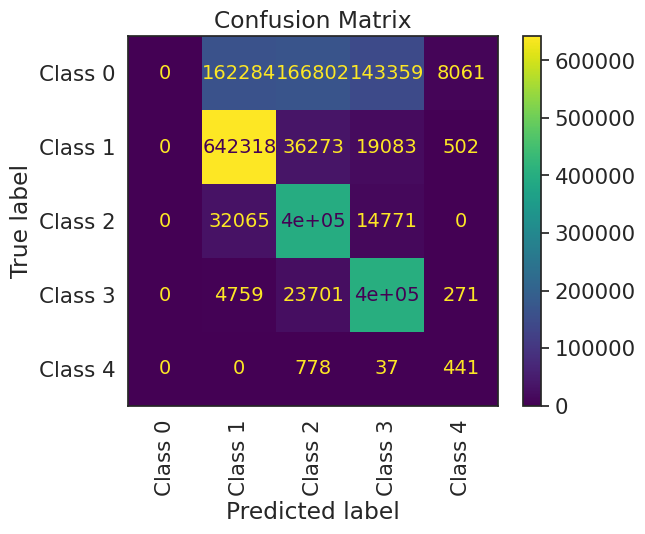

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, num_classes, class_names=None):
    """
    Plots the confusion matrix for a semantic segmentation task.

    Parameters:
        y_true (numpy array): Ground truth mask (flattened).
        y_pred (numpy array): Predicted mask (flattened).
        num_classes (int): Number of classes.
        class_names (list): Names of the classes (optional).

    Returns:
        None
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(include_values=True, cmap="viridis", xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()

# Example Usage
# Assuming `y_true` is your ground truth and `y_pred` is your model's predictions
y_true_flat = np.argmax(y_val,axis=-1).flatten()  # Flatten ground truth
y_pred_flat = preds.flatten()  # Flatten predictions

# Define the number of classes and class names
num_classes = len(np.unique(y_true_flat))
class_names = [f"Class {i}" for i in range(num_classes)]

# Plot the confusion matrix
plot_confusion_matrix(y_true_flat, y_pred_flat, num_classes, class_names)


In [15]:
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred, num_classes, class_names=None):
    """
    Prints the classification report for a semantic segmentation task.

    Parameters:
        y_true (numpy array): Ground truth mask (flattened).
        y_pred (numpy array): Predicted mask (flattened).
        num_classes (int): Number of classes.
        class_names (list): Names of the classes (optional).

    Returns:
        None
    """
    # Generate classification report
    report = classification_report(
        y_true, y_pred, labels=np.arange(num_classes), target_names=class_names
    )
    print(report)

# Example Usage
print_classification_report(y_true_flat, y_pred_flat, num_classes, class_names)


              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00    480506
     Class 1       0.76      0.92      0.83    698176
     Class 2       0.64      0.89      0.74    445318
     Class 3       0.69      0.93      0.80    430936
     Class 4       0.05      0.35      0.08      1256

    accuracy                           0.70   2056192
   macro avg       0.43      0.62      0.49   2056192
weighted avg       0.54      0.70      0.61   2056192



In [16]:
def mean_iou(y_true, y_pred, num_classes):
    """
    Computes the Mean Intersection Over Union (IoU) for a semantic segmentation task.

    Parameters:
        y_true (numpy array): Ground truth mask (flattened).
        y_pred (numpy array): Predicted mask (flattened).
        num_classes (int): Number of classes.

    Returns:
        float: Mean IoU score.
    """
    iou_per_class = []
    for c in range(num_classes):
        intersection = np.logical_and(y_true == c, y_pred == c).sum()
        union = np.logical_or(y_true == c, y_pred == c).sum()
        if union == 0:
            iou_per_class.append(float('nan'))  # Ignore if no pixels for class
        else:
            iou_per_class.append(intersection / union)
    return np.nanmean(iou_per_class)

# Example Usage
mean_iou_score = mean_iou(y_true_flat, y_pred_flat, num_classes)
print(f"Mean IoU: {mean_iou_score:.2f}")


Mean IoU: 0.40
